In [17]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [18]:
# import dataframe
col_list = ['video_id', 'translation']

df = pd.read_csv('C:/Users/bj-sa/Desktop/Database/translated_subtitles_scores.csv', usecols=col_list)
df = df.groupby('video_id').translation.agg(' '.join).reset_index()
df

,video_id,translation
0,--kmm2el4tE,This man no longer has a title: that of the ri...
1,-7ZJb38ADug,Not possible
2,-GhKEWuDc_M,Welcome to Interesting Short Documentaries\n! ...
3,-L_JoOgQ.en,Music playing! music playing! music playing! h...
4,-W4GQXTc.en,Over 26 billion tons For each American it's ab...
...,...,...
526,zbrYuCOE.en,The creation of a global cashless society\nhas...
527,zdeT2i9k.en,Bill Gates Real Story | Biography Of Bill Gate...
528,zmtxU8q6ohA,We live in a time of extraordinary inequality....
529,zrQaEybc4u4,Not possible


In [19]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 've'])

In [20]:
# Convert to list
data = df.translation.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['This man no longer has a title: that of the richest man on earth. And Bill '
 'Gates has it all for himself got together. By giving money away. He would '
 'prefer to do that much more, but he cant. Gates was the richest man '
 'overtaken by the Amazon CEO Jeff Bezos. He got a few billion more this year '
 'and now stands at about 100 billion dollars. Bill Gates, yes he did just '
 'that little bit this year less well. And must now settle for the second '
 'place. Thats not because his company Microsoft is doing so badly, or because '
 'he made a bad investment. No, its because Gates has so much money given away '
 'to charities. He gave $ 4.6 billion this year own charity, the Bill and '
 'Melinda Gates Foundation. It was the greatest donation of the century. For '
 'comparison: the Netherlands budgeted 4.5 billion euros for development aid. '
 'But even that mega gift is not enough to keep up with the growth of his '
 'assets. That grew by $ 9 billion this year. And that happened m

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['this', 'man', 'no', 'longer', 'has', 'title', 'that', 'of', 'the', 'richest', 'man', 'on', 'earth', 'and', 'bill', 'gates', 'has', 'it', 'all', 'for', 'himself', 'got', 'together', 'by', 'giving', 'money', 'away', 'he', 'would', 'prefer', 'to', 'do', 'that', 'much', 'more', 'but', 'he', 'cant', 'gates', 'was', 'the', 'richest', 'man', 'overtaken', 'by', 'the', 'amazon', 'ceo', 'jeff', 'bezos', 'he', 'got', 'few', 'billion', 'more', 'this', 'year', 'and', 'now', 'stands', 'at', 'about', 'billion', 'dollars', 'bill', 'gates', 'yes', 'he', 'did', 'just', 'that', 'little', 'bit', 'this', 'year', 'less', 'well', 'and', 'must', 'now', 'settle', 'for', 'the', 'second', 'place', 'thats', 'not', 'because', 'his', 'company', 'microsoft', 'is', 'doing', 'so', 'badly', 'or', 'because', 'he', 'made', 'bad', 'investment', 'no', 'its', 'because', 'gates', 'has', 'so', 'much', 'money', 'given', 'away', 'to', 'charities', 'he', 'gave', 'billion', 'this', 'year', 'own', 'charity', 'the', 'bill', 'and

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['this', 'man', 'no', 'longer', 'has', 'title', 'that', 'of', 'the', 'richest_man', 'on', 'earth', 'and', 'bill', 'gates', 'has', 'it', 'all', 'for', 'himself', 'got', 'together', 'by', 'giving', 'money', 'away', 'he', 'would', 'prefer', 'to', 'do', 'that', 'much', 'more', 'but', 'he', 'cant', 'gates', 'was', 'the', 'richest_man', 'overtaken', 'by', 'the', 'amazon', 'ceo_jeff', 'bezos', 'he', 'got', 'few', 'billion', 'more', 'this', 'year', 'and', 'now', 'stands', 'at', 'about', 'billion', 'dollars', 'bill', 'gates', 'yes', 'he', 'did', 'just', 'that', 'little_bit', 'this', 'year', 'less', 'well', 'and', 'must', 'now', 'settle', 'for', 'the', 'second', 'place', 'thats', 'not', 'because', 'his', 'company', 'microsoft', 'is', 'doing', 'so', 'badly', 'or', 'because', 'he', 'made', 'bad', 'investment', 'no', 'its', 'because', 'gates', 'has', 'so', 'much', 'money', 'given', 'away', 'to', 'charities', 'he', 'gave', 'billion', 'this', 'year', 'own', 'charity', 'the', 'bill', 'and', 'melinda',

In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['man', 'long', 'title', 'earth', 'gate', 'get', 'together', 'give', 'money', 'away', 'would', 'prefer', 'much', 'can', 'gate', 'get', 'year', 'stand', 'dollar', 'bill', 'gate', 'little_bit', 'year', 'less', 'well', 'must', 'settle', 'second', 'place', 's', 'company', 'badly', 'make', 'bad', 'investment', 'gate', 'much', 'money', 'give', 'charity', 'give', 'year', 'charity', 'great', 'donation', 'century', 'comparison', 'budget', 'euro', 'development', 'aid', 'even', 'mega', 'gift', 'enough', 'keep', 'growth', 'asset', 'grow', 'year', 'happen', 'much', 'often', 'give', 'away', 'wealth', 'go', 'crazy', 'year', 'work', 'way', 'good', 'bill', 'money', 'also', 'gate', 'wealth', 'increase', 'fast', 'money', 'give', 'charity', 'even', 'give', 'look', 'see', 'gate', 'ability', 'grow', 'fast', 'give', 'small', 'dip', 'however', 'still', 'spend', 'much', 'charity', 'equity', 'grow', 'fast', 'could', 'say', 'may', 'good', 'thing', 'gate', 'give', 'money', 'give', 'money', 'away', 'also', 'give'

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 3), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 5), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 1), (40, 8), (41, 2), (42, 1), (43, 13), (44, 2), (45, 1), (46, 3), (47, 1), (48, 4), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 10), (74, 4), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 3), (102, 1), (103, 1), (104, 1), (105, 3), (106, 1), (107, 2), (108, 4), (109, 1), (110, 

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"gate" + 0.024*"vaccine" + 0.016*"global" + 0.014*"health" + '
  '0.014*"world" + 0.012*"government" + 0.009*"public" + 0.009*"fund" + '
  '0.008*"bill" + 0.008*"year"'),
 (1,
  '0.000*"know" + 0.000*"go" + 0.000*"people" + 0.000*"thing" + 0.000*"lot" + '
  '0.000*"much" + 0.000*"s" + 0.000*"make" + 0.000*"good" + 0.000*"see"'),
 (2,
  '0.041*"alzheimer" + 0.007*"tier" + 0.005*"dementia" + '
  '0.004*"categorization" + 0.002*"bike" + 0.002*"translation" + '
  '0.002*"hans_rosling" + 0.002*"culminate" + 0.002*"statistician" + '
  '0.000*"therein"'),
 (3,
  '0.015*"epidemic" + 0.011*"virus" + 0.009*"vaccine" + 0.008*"gate" + '
  '0.008*"thank" + 0.008*"say" + 0.008*"global" + 0.008*"already" + '
  '0.007*"world" + 0.007*"next"'),
 (4,
  '0.041*"ice" + 0.035*"suck" + 0.015*"drone" + 0.007*"holiday" + '
  '0.004*"manifest" + 0.004*"sleeping" + 0.003*"meditation" + '
  '0.003*"selection" + 0.002*"meditate" + 0.001*"manif"'),
 (5,
  '0.011*"steam" + 0.001*"sin" + 0.001*"forgive

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.618061259053622

Coherence Score:  0.39822169412765795


In [29]:
from gensim.models.wrappers import LdaMallet
mallet_path = 'C:/mallet-2.0.8/bin/mallet' 


ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('vaccine', 0.056551985234962854),
   ('gate', 0.02394586153045289),
   ('global', 0.02072784061331693),
   ('health', 0.018645591784581896),
   ('fund', 0.014575741801145237),
   ('public', 0.012067578439259855),
   ('foundation', 0.011215749372959159),
   ('government', 0.011026454024892338),
   ('world', 0.010837158676825517),
   ('develop', 0.01060053949174199)]),
 (1,
  [('year', 0.04366543665436654),
   ('make', 0.03905289052890529),
   ('work', 0.032656826568265684),
   ('money', 0.027982779827798277),
   ('people', 0.02730627306273063),
   ('kid', 0.01968019680196802),
   ('child', 0.01845018450184502),
   ('thing', 0.015006150061500615),
   ('world', 0.014698646986469865),
   ('big', 0.014575645756457565)]),
 (2,
  [('control', 0.014519650655021834),
   ('gate', 0.013700873362445415),
   ('population', 0.012718340611353712),
   ('system', 0.012718340611353712),
   ('government', 0.012718340611353712),
   ('child', 0.011844978165938864),
   ('people', 0.0097161572052401

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


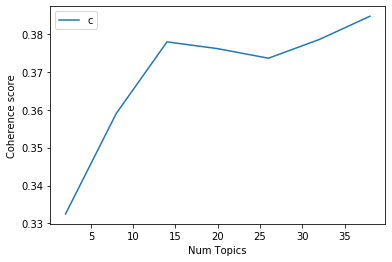

In [34]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3325
Num Topics = 8  has Coherence Value of 0.359
Num Topics = 14  has Coherence Value of 0.3779
Num Topics = 20  has Coherence Value of 0.3761
Num Topics = 26  has Coherence Value of 0.3736
Num Topics = 32  has Coherence Value of 0.3785
Num Topics = 38  has Coherence Value of 0.3846


In [36]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.088*"gate" + 0.061*"bill" + 0.018*"money" + 0.017*"billionaire" + '
  '0.017*"world" + 0.016*"dollar" + 0.016*"year" + 0.012*"company" + '
  '0.012*"computer" + 0.011*"share"'),
 (1,
  '0.046*"people" + 0.027*"woman" + 0.022*"feel" + 0.021*"give" + '
  '0.019*"family" + 0.018*"happen" + 0.016*"child" + 0.016*"thing" + '
  '0.014*"talk" + 0.014*"bill"'),
 (2,
  '0.036*"thing" + 0.028*"software" + 0.027*"company" + 0.018*"computer" + '
  '0.016*"people" + 0.016*"year" + 0.013*"lot" + 0.012*"apple" + '
  '0.012*"product" + 0.011*"business"'),
 (3,
  '0.025*"make" + 0.021*"epidemic" + 0.020*"time" + 0.018*"spread" + '
  '0.018*"people" + 0.017*"thing" + 0.016*"ready" + 0.015*"create" + '
  '0.013*"virus" + 0.012*"happen"'),
 (4,
  '0.024*"world" + 0.023*"virus" + 0.013*"seed" + 0.013*"pandemic" + '
  '0.011*"kill" + 0.009*"population" + 0.009*"people" + 0.009*"video" + '
  '0.009*"fear" + 0.009*"news"'),
 (5,
  '0.024*"make" + 0.022*"energy" + 0.016*"water" + 0.015*"world" + '
  

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2020,"gate, bill, money, billionaire, world, dollar,...",This man no longer has a title: that of the ri...
1,1,0.0,0.0500,"gate, bill, money, billionaire, world, dollar,...",Not possible
2,2,4.0,0.2345,"world, virus, seed, pandemic, kill, population...",Welcome to Interesting Short Documentaries ! T...
3,3,4.0,0.2669,"world, virus, seed, pandemic, kill, population...",Music playing! music playing! music playing! h...
4,4,4.0,0.3123,"world, virus, seed, pandemic, kill, population...",Over 26 billion tons For each American its abo...
5,5,9.0,0.1493,"people, test, country, thing, number, lot, bac...","""We dont trust this model. The code is unknown..."
6,6,3.0,0.4587,"make, epidemic, time, spread, people, thing, r...","As a child, the catastrophe that most concerne..."
7,7,4.0,0.2912,"world, virus, seed, pandemic, kill, population...",Hello and welcome to the interview for France2...
8,8,2.0,0.5345,"thing, software, company, computer, people, ye...",Ive invited here today 3 industry experts to h...
9,9,4.0,0.2197,"world, virus, seed, pandemic, kill, population...",Translated by BrasiLIndomaveL.com.br Submitted...


In [41]:
df_dominant_topic.to_csv('vidtext_topics.csv')